In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, classification_report, accuracy_score
from sklearn.decomposition import PCA

In [5]:
data = pd.read_csv('/kaggle/input/ecommerce-customerssales-record/Sales.csv')

In [14]:
column_mapping = {
    'DAYSSINCELASTORDER':'days_since_last_order',
    'TOTAL_ORDERS': 'total_orders',
    'REVENUE':'revenue',
    'AVERAGE_ORDER_VALUE':'average_order_value',
    'AVGDAYSBETWEENORDERS':'avg_days_between_orders'
}
data.rename(columns=column_mapping,inplace=True)


if 'days_since_last_order' in data.columns:
    data['recency'] = data['days_since_last_order']
else:
    data['recency']=0

if 'total_orders' in data.columns:
    data['frequency'] = data['total_orders']
else:
    data['frequency']=0

if 'revenue' in data.columns:
    data['monetary'] = data['revenue']
else:
    data['monetary']=0

data['recency_score'] =pd.qcut(data['recency'].rank(method='first'),4,labels=[4, 3, 2, 1],duplicates='drop')
data['frequency_score'] = pd.qcut(data['frequency'].rank(method='first'),4,labels=[1, 2, 3, 4],duplicates='drop')
data['monetary_score'] = pd.qcut(data['monetary'].rank(method='first'),4,labels=[1, 2, 3, 4],duplicates='drop')


data['rfm_score'] = (data['recency_score'].astype(int) +data['frequency_score'].astype(int) +data['monetary_score'].astype(int))

if 'average_order_value' in data.columns:
    data['avg_order']=data['average_order_value']
else:
    data['avg_order'] = data['revenue'] / data['total_orders'].replace(0, 1)

data['avg_order'].fillna(0, inplace=True)

features = ['total_orders','avg_days_bw_orders','rfm_score','avg_order']
features = [f for f in features if f in data.columns]

/tmp/ipykernel_47/2736118919.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['avg_order'].fillna(0, inplace=True)


In [9]:
X = data[features].fillna(0)
y = data['revenue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster characteristics:
         revenue  total_orders  recency  frequency
cluster                                           
0        2964.85         22.70    63.03      22.70
1         409.60          3.98   188.93       3.98
2         721.96          6.90    26.06       6.90
3        7971.88         43.67    60.57      43.67


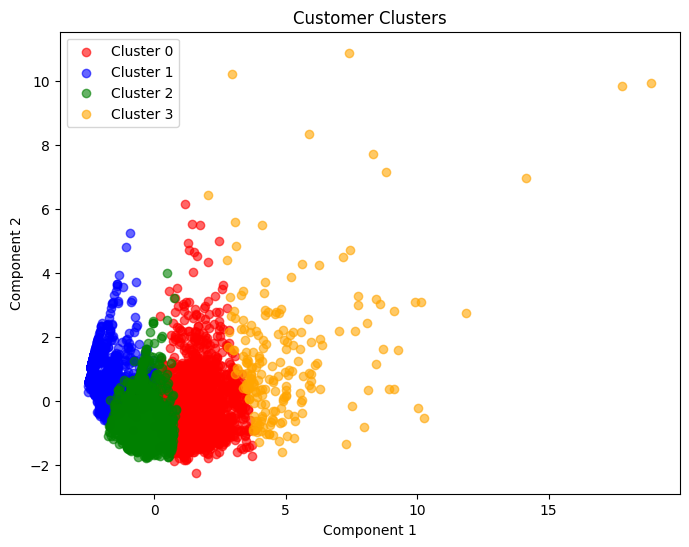

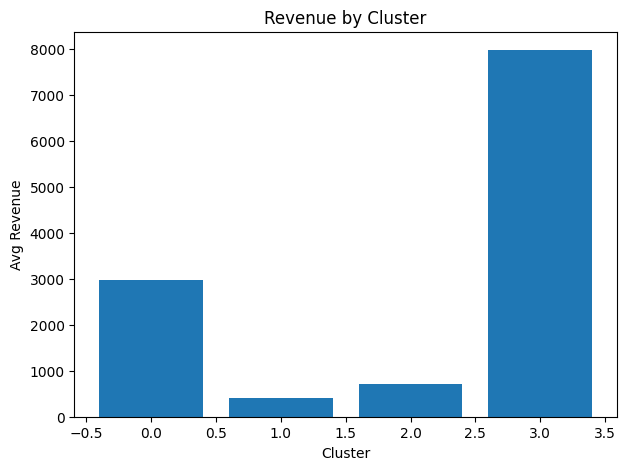


--- Cluster Prediction Accuracy ---
Accuracy: 0.983

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       395
           1       0.99      0.99      0.99       379
           2       0.98      0.98      0.98       427
           3       1.00      0.96      0.98        49

    accuracy                           0.98      1250
   macro avg       0.99      0.98      0.98      1250
weighted avg       0.98      0.98      0.98      1250



In [12]:
lr= LinearRegression()
lr.fit(X_train,y_train)
pred= lr.predict(X_test)

rf= RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train,y_train)
rf_pred= rf.predict(X_test)

rf.fit(X, y)
data['predicted_rev'] = rf.predict(X)
data['difference'] = data['revenue'] - data['predicted_rev']

cluster_features= ['rfm_score','recency','frequency','monetary','avg_order','predicted_rev']
cluster_features= [f for f in cluster_features if f in data.columns]

X_cluster=data[cluster_features].fillna(0)

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X_cluster)

n_clusters=4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(X_scaled)

print('\nCluster characteristics:')
cluster_summary = data.groupby('cluster')[['revenue','total_orders','recency','frequency']].mean()
print(cluster_summary.round(2))

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
colors = ['red','blue','green','black','pink']
for i in range(n_clusters):
    mask = data['cluster'] == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               label=f'Cluster {i}', alpha=0.6, c=colors[i])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.title('Customer Clusters')
plt.show()

avg_revenues = data.groupby('cluster')['revenue'].mean()
plt.figure(figsize=(7,5))
plt.bar(range(n_clusters), avg_revenues)
plt.xlabel('Cluster')
plt.ylabel('Avg Revenue')
plt.title('Revenue by Cluster')
plt.show()

data['segment_name'] = data['cluster'].map(cluster_names)

print('Cluster Prediction Accuracy')
X_class = X_scaled
y_class = data['cluster']

X_tr,X_te,y_tr,y_te = train_test_split(X_class,y_class,test_size=0.25, random_state=42)

clf = RandomForestClassifier(n_estimators=100,random_state=42)
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_te)

print(f'Accuracy: {accuracy_score(y_te,y_pred):.3f}')
print('\nClassification Report:')
print(classification_report(y_te,y_pred))
